<a href="https://colab.research.google.com/github/ifeeney/CS_Thesis/blob/main/MaskFromFP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First define data sources

In [93]:
import numpy as np
import trimesh

# Load CAD model
mesh = trimesh.load("centered_finger_simple.obj")

# Camera intrinsics matrix K
K = np.loadtxt('cam_K.txt')

# Load RGB images
video_dir = "./rgb"

# Load object positions
pose_dir = "./obs_in_cam"

# Mask from FoundationPose Prediction

In [114]:
import cv2

def create_frame_mask(pose_matrix, vertices, faces, camK):

  # Convert 3D object vertices to 4D homogeneous coordinates
  vertices_homo = np.hstack([vertices, np.ones((vertices.shape[0], 1))])  # (N, 4)

  # Transform vertices from object space to camera space
  vertices_cam = (pose_matrix @ vertices_homo.T).T[:, :3]  # (N, 3)

  # Perspective projection (project onto the image plane)
  pixels = (K @ (vertices_cam / vertices_cam[:, 2, None]).T).T  # (N, 3)

  # Normalize to pixel coordinates
  u, v = pixels[:, 0], pixels[:, 1]
  pixel_coords = np.vstack([u, v]).T.astype(int)

  # Create an empty mask
  img_height, img_width = 480, 640  # Change based on your image size
  cad_mask = np.zeros((img_height, img_width), dtype=np.uint8)

  for face in faces:  # 'faces' should contain the triangle vertex indices
      tri_verts = pixel_coords[face]  # Get 2D projected triangle vertices
      cv2.fillPoly(cad_mask, [tri_verts], 255)

  return cad_mask

In [115]:
# Get properties of CAD model
vertices = np.array(mesh.vertices)  # (N, 3) array of 3D points
faces = np.array(mesh.faces)

# Get mask for each frame
cad_masks = {}

for idx, filename in enumerate(os.listdir(pose_dir)):
  if not filename.endswith(".txt"):
    break
  T_obj_to_cam = np.loadtxt(os.path.join(pose_dir, filename))
  frame_mask = create_frame_mask(T_obj_to_cam, vertices, faces, K)
  cad_masks[idx] = frame_mask


preview first mask

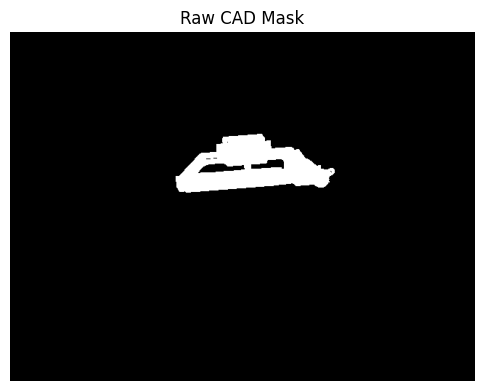

In [116]:
first_frame_mask = create_frame_mask(T_obj_to_cam, vertices, faces, K)

plt.figure(figsize=(6, 6))
plt.title("Raw CAD Mask")
plt.imshow(first_frame_mask, cmap="gray")  # Show the raw binary mask
plt.axis("off")
plt.show()

# Mask from SAM2

## Setup code from SAM2 video_predictor_example.ipynb

In [2]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam2.git'

#!mkdir -p videos
#!wget -P videos https://dl.fbaipublicfiles.com/segment_anything_2/assets/bedroom.zip
#!unzip -d videos videos/bedroom.zip

!mkdir -p ../checkpoints/
!wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt

PyTorch version: 2.5.1+cu124
Torchvision version: 0.20.1+cu124
CUDA is available: True
  Cloning https://github.com/facebookresearch/sam2.git to /tmp/pip-req-build-30f1yd10
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/sam2.git /tmp/pip-req-build-30f1yd10
  Resolved https://github.com/facebookresearch/sam2.git to commit 2b90b9f5ceec907a1c18123530e92e794ad901a4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cache

In [3]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [4]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


In [5]:
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

In [6]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

## Initalize points for masking

Convert all images to jpg format

In [9]:
from PIL import Image

for filename in os.listdir(video_dir):
    if filename.lower().endswith(".png"):
        png_path = os.path.join(video_dir, filename)
        jpg_path = os.path.join(video_dir, os.path.splitext(filename)[0] + ".jpg")

        im = Image.open(png_path)
        rgb_im = im.convert('RGB')
        rgb_im.save(jpg_path)

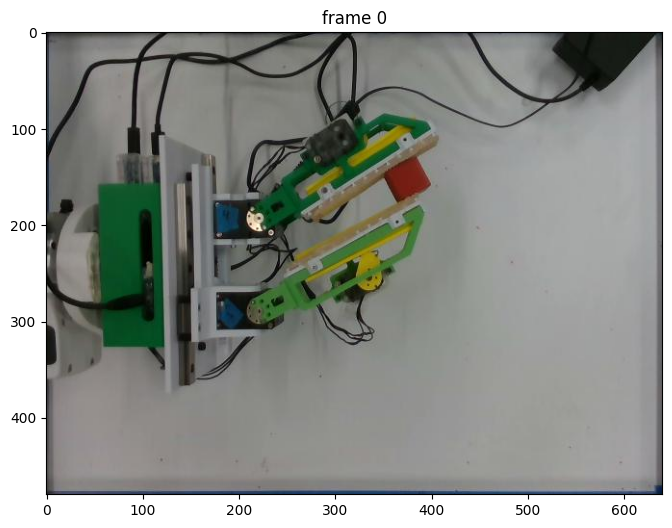

In [10]:
#video_dir = "./videos/bedroom"

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 0
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))

In [11]:
inference_state = predictor.init_state(video_path=video_dir)

frame loading (JPEG): 100%|██████████| 18/18 [00:00<00:00, 32.38it/s]


In [14]:
predictor.reset_state(inference_state)

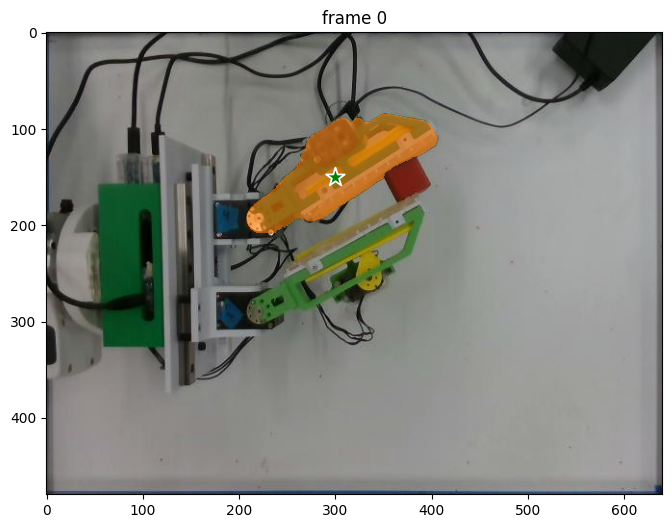

In [15]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

# Let's add a positive click at (x, y) = (210, 350) to get started
points = np.array([[300, 150]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], np.int32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

propagate in video: 100%|██████████| 18/18 [00:19<00:00,  1.06s/it]


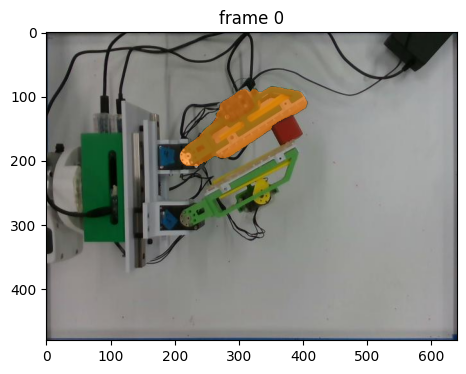

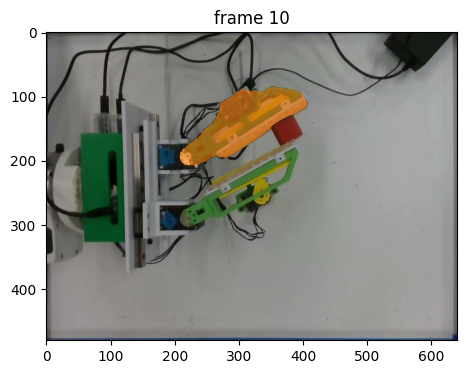

In [68]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results every few frames
vis_frame_stride = 10
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

# Calculate IOU

In [64]:
# Fix SAM mask shape
sam_mask = (out_mask_logits[0] > 0.0).cpu().numpy().astype(np.uint8).squeeze(0)

In [65]:
# Ensure CAD mask is binary
cad_mask = cad_mask.astype(np.uint8)

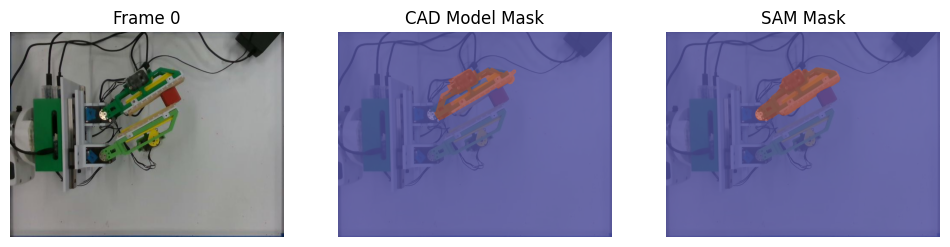

IoU between CAD mask and SAM mask: 0.7198


In [66]:
# Load the original frame image
frame_img = Image.open(os.path.join(video_dir, frame_names[ann_frame_idx]))

# Plot results
plt.figure(figsize=(12, 6))

# Original frame
plt.subplot(1, 3, 1)
plt.title(f"Frame {ann_frame_idx}")
plt.imshow(frame_img)
plt.axis("off")

# CAD model mask overlay
plt.subplot(1, 3, 2)
plt.title("CAD Model Mask")
plt.imshow(frame_img, alpha=0.5)
plt.imshow(cad_mask, cmap="jet", alpha=0.5)
plt.axis("off")

# SAM mask overlay
plt.subplot(1, 3, 3)
plt.title("SAM Mask")
plt.imshow(frame_img, alpha=0.5)
plt.imshow(sam_mask, cmap="jet", alpha=0.5)
plt.axis("off")

plt.show()

# Compute IoU (Intersection over Union)
intersection = np.logical_and(cad_mask, sam_mask).sum()
union = np.logical_or(cad_mask, sam_mask).sum()
iou = intersection / union if union > 0 else 0
print(f"IoU between CAD mask and SAM mask: {iou:.4f}")


<Figure size 1200x600 with 0 Axes>

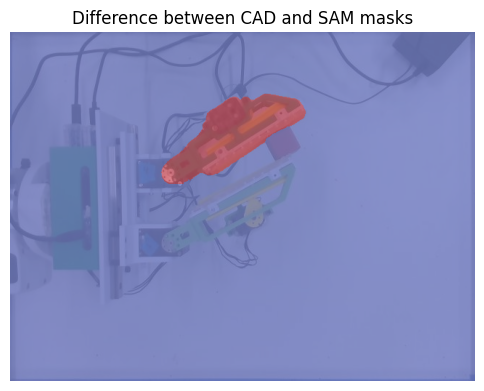

In [52]:
# Load the current frame image
frame_img = Image.open(os.path.join(video_dir, frame_names[ann_frame_idx]))

# Plot results
plt.figure(figsize=(12, 6))

diff_mask = np.zeros_like(cad_mask)
diff_mask[cad_mask == 1] = 1  # CAD mask in red
diff_mask[sam_mask == 1] = 2  # SAM mask in blue
diff_mask[(cad_mask == 1) & (sam_mask == 1)] = 3  # Overlapping in purple

plt.figure(figsize=(6, 6))
plt.title("Difference between CAD and SAM masks")
plt.imshow(frame_img, alpha=0.5)
plt.imshow(diff_mask, cmap="coolwarm", alpha=0.5)
plt.axis("off")
plt.show()